## Seguimiento - Action-based Expected Threat

Calculando xT desde la obtención de cadenas de posesión.

In [1]:
import pandas as pd
import json
# plotting
import os
import pathlib
import warnings 
from joblib import load
from mplsoccer import Pitch
from itertools import combinations_with_replacement
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBRegressor,XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

C:\Users\aleex\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
path = os.path.join(str(pathlib.Path().resolve()), 'data', 'Wyscout','chains', 'possession_chains_england.csv')
df = pd.read_csv(path,sep=';')
df.head()

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,xG,shot_end,x,y,Cy,end_x,end_y,Cend_y,Cx,Cend_x
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,...,0.0,0,51.45,34.68,0.68,32.55,14.96,19.04,53.55,72.45
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,...,0.0,0,32.55,14.96,19.04,53.55,17.00,17.00,72.45,51.45
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,...,0.0,0,53.55,17.00,17.00,36.75,19.72,14.28,51.45,68.25
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,...,0.0,0,36.75,19.72,14.28,43.05,3.40,30.60,68.25,61.95
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,...,0.0,0,43.05,3.40,30.60,75.60,8.16,25.84,61.95,29.40


### Preparación de Variables

Dado que vamos a modelar con ML, debemos antes preparar bien las variables que se utilizarán. Tenemos que tomar, en este caso, los puntos x de inicio y fin de acción + la distancia con el centro horizontal de inicio y fin (lo que denominamos Cy y Cend_y).

Crearemos combinaciones entre las variables que las vayan reemplazar para tomar sus transformaciones no-lineales. Para acabar, multiplicamos las columnas de cada combinación.

In [3]:
var = ["x", "end_x", "Cy", "Cend_y"]

In [4]:
#combinations
inputs = []

inputs.extend(combinations_with_replacement(var, 1))
#one variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

In [5]:
for i in inputs[:5]:
    print(i)

('x',)
('end_x',)
('Cy',)
('Cend_y',)
('x',)


In [6]:
print(type(inputs[0]))
print(type(inputs[0][0]))
for inp in inputs:
    print(len(inp))

<class 'tuple'>
<class 'str'>
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


In [7]:
for i in inputs:
    if len(i)>1:
        col= ''
        x=1
        
        for c in i:
            col+=c
            #print(col)
            
            x = x * df[c]
            
        df[col] = x
        var.append(col)
        
df.head()

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,end_xend_xend_x,end_xend_xCy,end_xend_xCend_y,end_xCyCy,end_xCyCend_y,end_xCend_yCend_y,CyCyCy,CyCyCend_y,CyCend_yCend_y,Cend_yCend_yCend_y
0,0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,...,34486.806375,720.4617,20172.9276,15.05112,421.43136,11800.07808,0.314432,8.804096,246.514688,6902.411264
1,1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,...,153560.113875,54599.1516,48749.2425,19413.03168,17333.06400,15475.95000,6902.411264,6162.867200,5502.560000,4913.000000
2,2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,...,49633.171875,22959.5625,19286.0325,10620.75000,8921.43000,7494.00120,4913.000000,4126.920000,3466.612800,2911.954752
3,3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,...,79784.672625,26465.1597,56711.0565,8778.68712,18811.47240,40310.29800,2911.954752,6239.903040,13371.220800,28652.616000
4,4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,...,432081.216000,174890.0160,147684.9024,70788.81600,59777.22240,50478.54336,28652.616000,24195.542400,20431.791360,17253.512704


### Entrenamiento - XGBoost

Empleamos un modelo de clasificación con XGBoost para predecir el resultado de una acción (si finalizará en tiro o no). En aquellas predichas como tal, aplicamos regresión lineal para calcular la probabilidad de que acabe en gol. El resultado será el xT.

In [8]:
# XGBoost gets AUC 0.2 higher than Logistic Regression

passes = df.loc[ df["eventName"].isin(["Pass"])]
X = passes[var].values
y = passes['shot_end'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
xgb = XGBClassifier(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,random_state=123)

scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print(np.mean(scores), np.std(scores))

xgb.fit(X_train, y_train)

0.9203981415613403 0.00014390930361520717
[12:33:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "ccp_alpha", "min_samples_leaf" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:33:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', ccp_alpha=0,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, min_samples_leaf=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

print('\n')
print('On training data')
print(xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)

print('\nAUC_SCORE: ')
print(roc_auc_score(y_test, y_pred))
print('\n')
print('On test data')
print(xgb.score(X_test, y_test))



On training data
0.9208462610558136

AUC_SCORE: 
0.5032322005032334


On test data
0.9206056256194675


In [10]:
xgb.save_model("./model/model_xT.json")

In [11]:
"""
# Vamos a plantear la opción de incluir como variable X a todas las acciones que impliquen movimiento

# XGBoost gets AUC 0.2 higher than Logistic Regression

move_df = df.loc[df["eventName"].isin(["Pass",'Duel'])]
X = move_df[var].values
y = move_df['shot_end'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)
xgb = XGBClassifier(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,random_state=123)

scores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)
print(np.mean(scores), np.std(scores))

xgb.fit(X_train, y_train)
"""

'\n# Vamos a plantear la opción de incluir como variable X a todas las acciones que impliquen movimiento\n\n# XGBoost gets AUC 0.2 higher than Logistic Regression\n\nmove_df = df.loc[df["eventName"].isin(["Pass",\'Duel\'])]\nX = move_df[var].values\ny = move_df[\'shot_end\'].values\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 123, stratify = y)\nxgb = XGBClassifier(n_estimators = 100, ccp_alpha=0, max_depth=4, min_samples_leaf=10,random_state=123)\n\nscores = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10, n_jobs = -1)\nprint(np.mean(scores), np.std(scores))\n\nxgb.fit(X_train, y_train)\n'

In [12]:
"""
print('\n')
print('On training data')
print(xgb.score(X_train, y_train))
y_pred = xgb.predict(X_test)

print('\nAUC_SCORE: ')
print(roc_auc_score(y_test, y_pred))
print('\n')
print('On test data')
print(xgb.score(X_test, y_test))
"""

"\nprint('\n')\nprint('On training data')\nprint(xgb.score(X_train, y_train))\ny_pred = xgb.predict(X_test)\n\nprint('\nAUC_SCORE: ')\nprint(roc_auc_score(y_test, y_pred))\nprint('\n')\nprint('On test data')\nprint(xgb.score(X_test, y_test))\n"

In [13]:
move_df = passes
y_pred_proba = xgb.predict_proba(X)[::,1]
move_df['shot_prob'] = y_pred_proba

shot_ended = move_df[move_df["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values

lr = LinearRegression()
lr.fit(X2,y2)

y_pred = lr.predict(X)
move_df["xG_pred"] = y_pred

move_df["xT"] = move_df["xG_pred"]*move_df["shot_prob"]

move_df[["xG_pred", "shot_prob", "xT"]].head(5)

,xG_pred,shot_prob,xT
0,0.121099,0.024302,0.002943
1,0.108244,0.051295,0.005552
2,0.121571,0.041173,0.005005
3,0.118808,0.036258,0.004308
4,0.116028,0.042168,0.004893


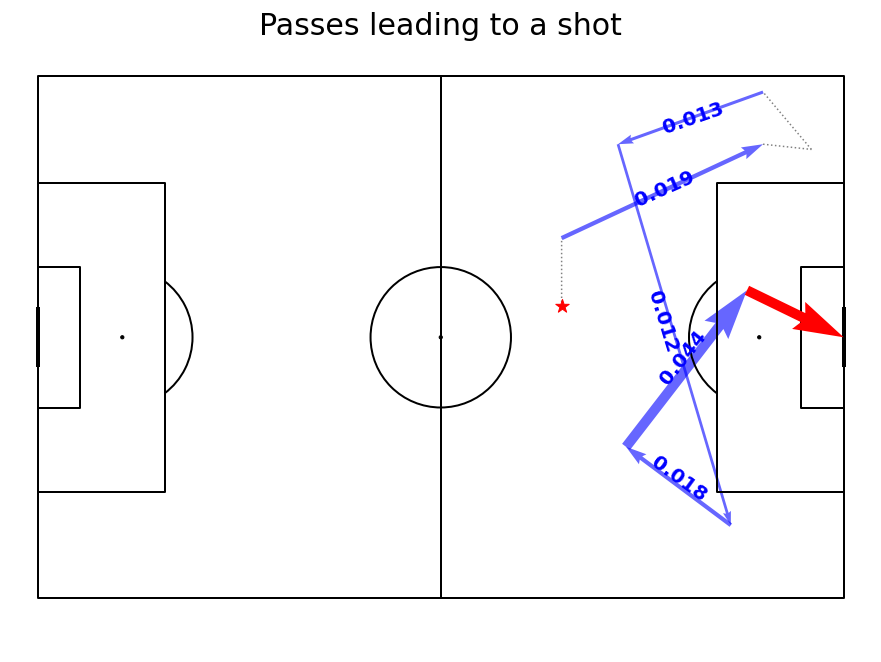

In [14]:
#get passes

chain = passes.loc[df["possesion_chain"] == 4]
max_value = chain["xT"].max()
#get events different than pass
not_pass = df.loc[(df["eventName"] != "Pass") & (df["eventName"] != "Shot") & (df.possesion_chain==4)]

#shot is the last event of the chain (or should be)
shot = df.loc[df["possesion_chain"] == 4].iloc[-1]
start = df.loc[df["possesion_chain"] == 4].iloc[0]
#plot
pitch = Pitch(line_color='black',pitch_type='uefa', line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#passes = chain[chain["eventName"] == "Pass"]
#add size adjusted arrows
for i, j in chain.iterrows():
    value = j["xT"]
    #adjust the line width so that the more passes, the wider the line
    line_width = (value / max_value * 10)
    #get angle
    angle = np.arctan((j.end_y-j.y)/(j.end_x-j.x))*180/np.pi
    #plot lines on the pitch
    pitch.arrows(j.x, j.y, j.end_x, j.end_y,
                        alpha=0.6, width=line_width, zorder=2, color="blue", ax = ax["pitch"])
    #annotate text
    ax["pitch"].text((j.x+j.end_x-8)/2, (j.y+j.end_y-4)/2, str(value)[:5], fontweight = "bold", color = "blue", zorder = 4, fontsize = 20, rotation = int(angle))

#shot
if shot['eventName'].values[0] == 
pitch.arrows(shot.x, shot.y,
            shot.end_x, shot.end_y, width=line_width, color = "red", ax=ax['pitch'], zorder =  3)
pitch.scatter(start.x, start.y, marker = '*', color = "red", ax=ax['pitch'], zorder =  3, s= 200)

#other passes like arrows
"""
for i,j in not_pass.iterrows():
    value = j["xT"]
    line_width= (value / max_value * 10)
    angle = np.arctan((j.end_y-j.y)/(j.end_x-j.x))*180/np.pi
    pitch.lines(j.x, j.y, j.end_x, j.end_y, color = "grey", lw = line_width, ls = 'dotted', ax=ax['pitch'])
    ax["pitch"].text((j.x+j.end_x-8)/2, (j.y+j.end_y-4)/2, str(value)[:5], color = "blue", zorder = 4, fontsize = 12, rotation = int(angle))
"""
pitch.lines(not_pass.x, not_pass.y, not_pass.end_x, not_pass.end_y, color = "grey", lw = 1.5, ls = 'dotted', ax=ax['pitch'])
ax['title'].text(0.5, 0.5, 'Passes leading to a shot', ha='center', va='center', fontsize=30)
plt.show()

In [15]:
summary = passes[["playerId", "xT"]].groupby(["playerId"]).sum().reset_index()
#add player name
path = os.path.join(str(pathlib.Path().resolve()),"data", 'WyScout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')
player_df.rename(columns = {'wyId':'playerId'}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis = 1)
to_merge = player_df[['playerId', 'shortName', 'role']]

summary = summary.merge(to_merge, how = "left", on = ["playerId"])

#get minutes
path = os.path.join(str(pathlib.Path().resolve()),"data", 'WyScout',"minutes_played", 'minutes_played_per_game_England.json')
with open(path) as f:
    minutes_per_game = json.load(f)
#filtering over 400 per game
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
#calculating per 90
summary["xT_p90"] = summary["xT"]*90/summary["minutesPlayed"]

#adjusting for possesion
path = os.path.join(str(pathlib.Path().resolve()),"data", 'WyScout',"minutes_played",  'player_possession_England.json')
with open(path) as f:
    percentage_df = json.load(f)
percentage_df = pd.DataFrame(percentage_df)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])
#adjust per possesion
summary["xT_adjusted_per_90"] = (summary["xT"]/summary["possesion"])*90/summary["minutesPlayed"]
summary[['shortName', 'xT_adjusted_per_90']].sort_values(by='xT_adjusted_per_90', ascending=False).head(20)

,shortName,xT_adjusted_per_90
22,M. Özil,1.523241
27,Fàbregas,1.426361
250,E. Hazard,1.376664
30,A. Sánchez,1.357268
117,David Silva,1.298201
271,K. De Bruyne,1.229572
39,Philippe Coutinho,1.215208
68,P. Pogba,1.191006
351,O. Zinchenko,1.147171
2,C. Eriksen,1.108392


#### Challenge

- Indian Superleague
- aplicar a un equipo de premier 17/18 y hacer mapa calor con bins